In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings

In [11]:
result = results.ResultSample.load_from_file(
    #"/home/gw/data/experiments/master_thesis/results/6d186e013e95a2b671786ba446de554c.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/fe40fbb72d77ab0c088536caa6593db9.tar.gz"
    "/home/gw/data/experiments/master_thesis/results/c6835cefcab68b58b6f07158f1137c83.tar.gz"
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()

normalized probabilities: [0.5665243  0.3504857  0.08298998]


samples_parameters_fs.shape (1274, 17)


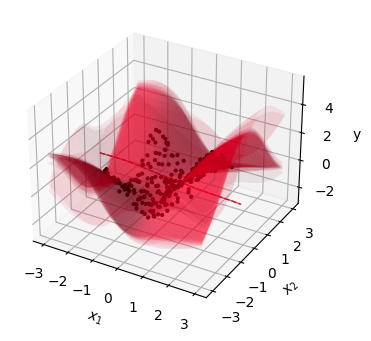

In [18]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))
samples_parameters_fs = jax.random.permutation(rng_key_, result.samples["parameters"])
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.55it/s]


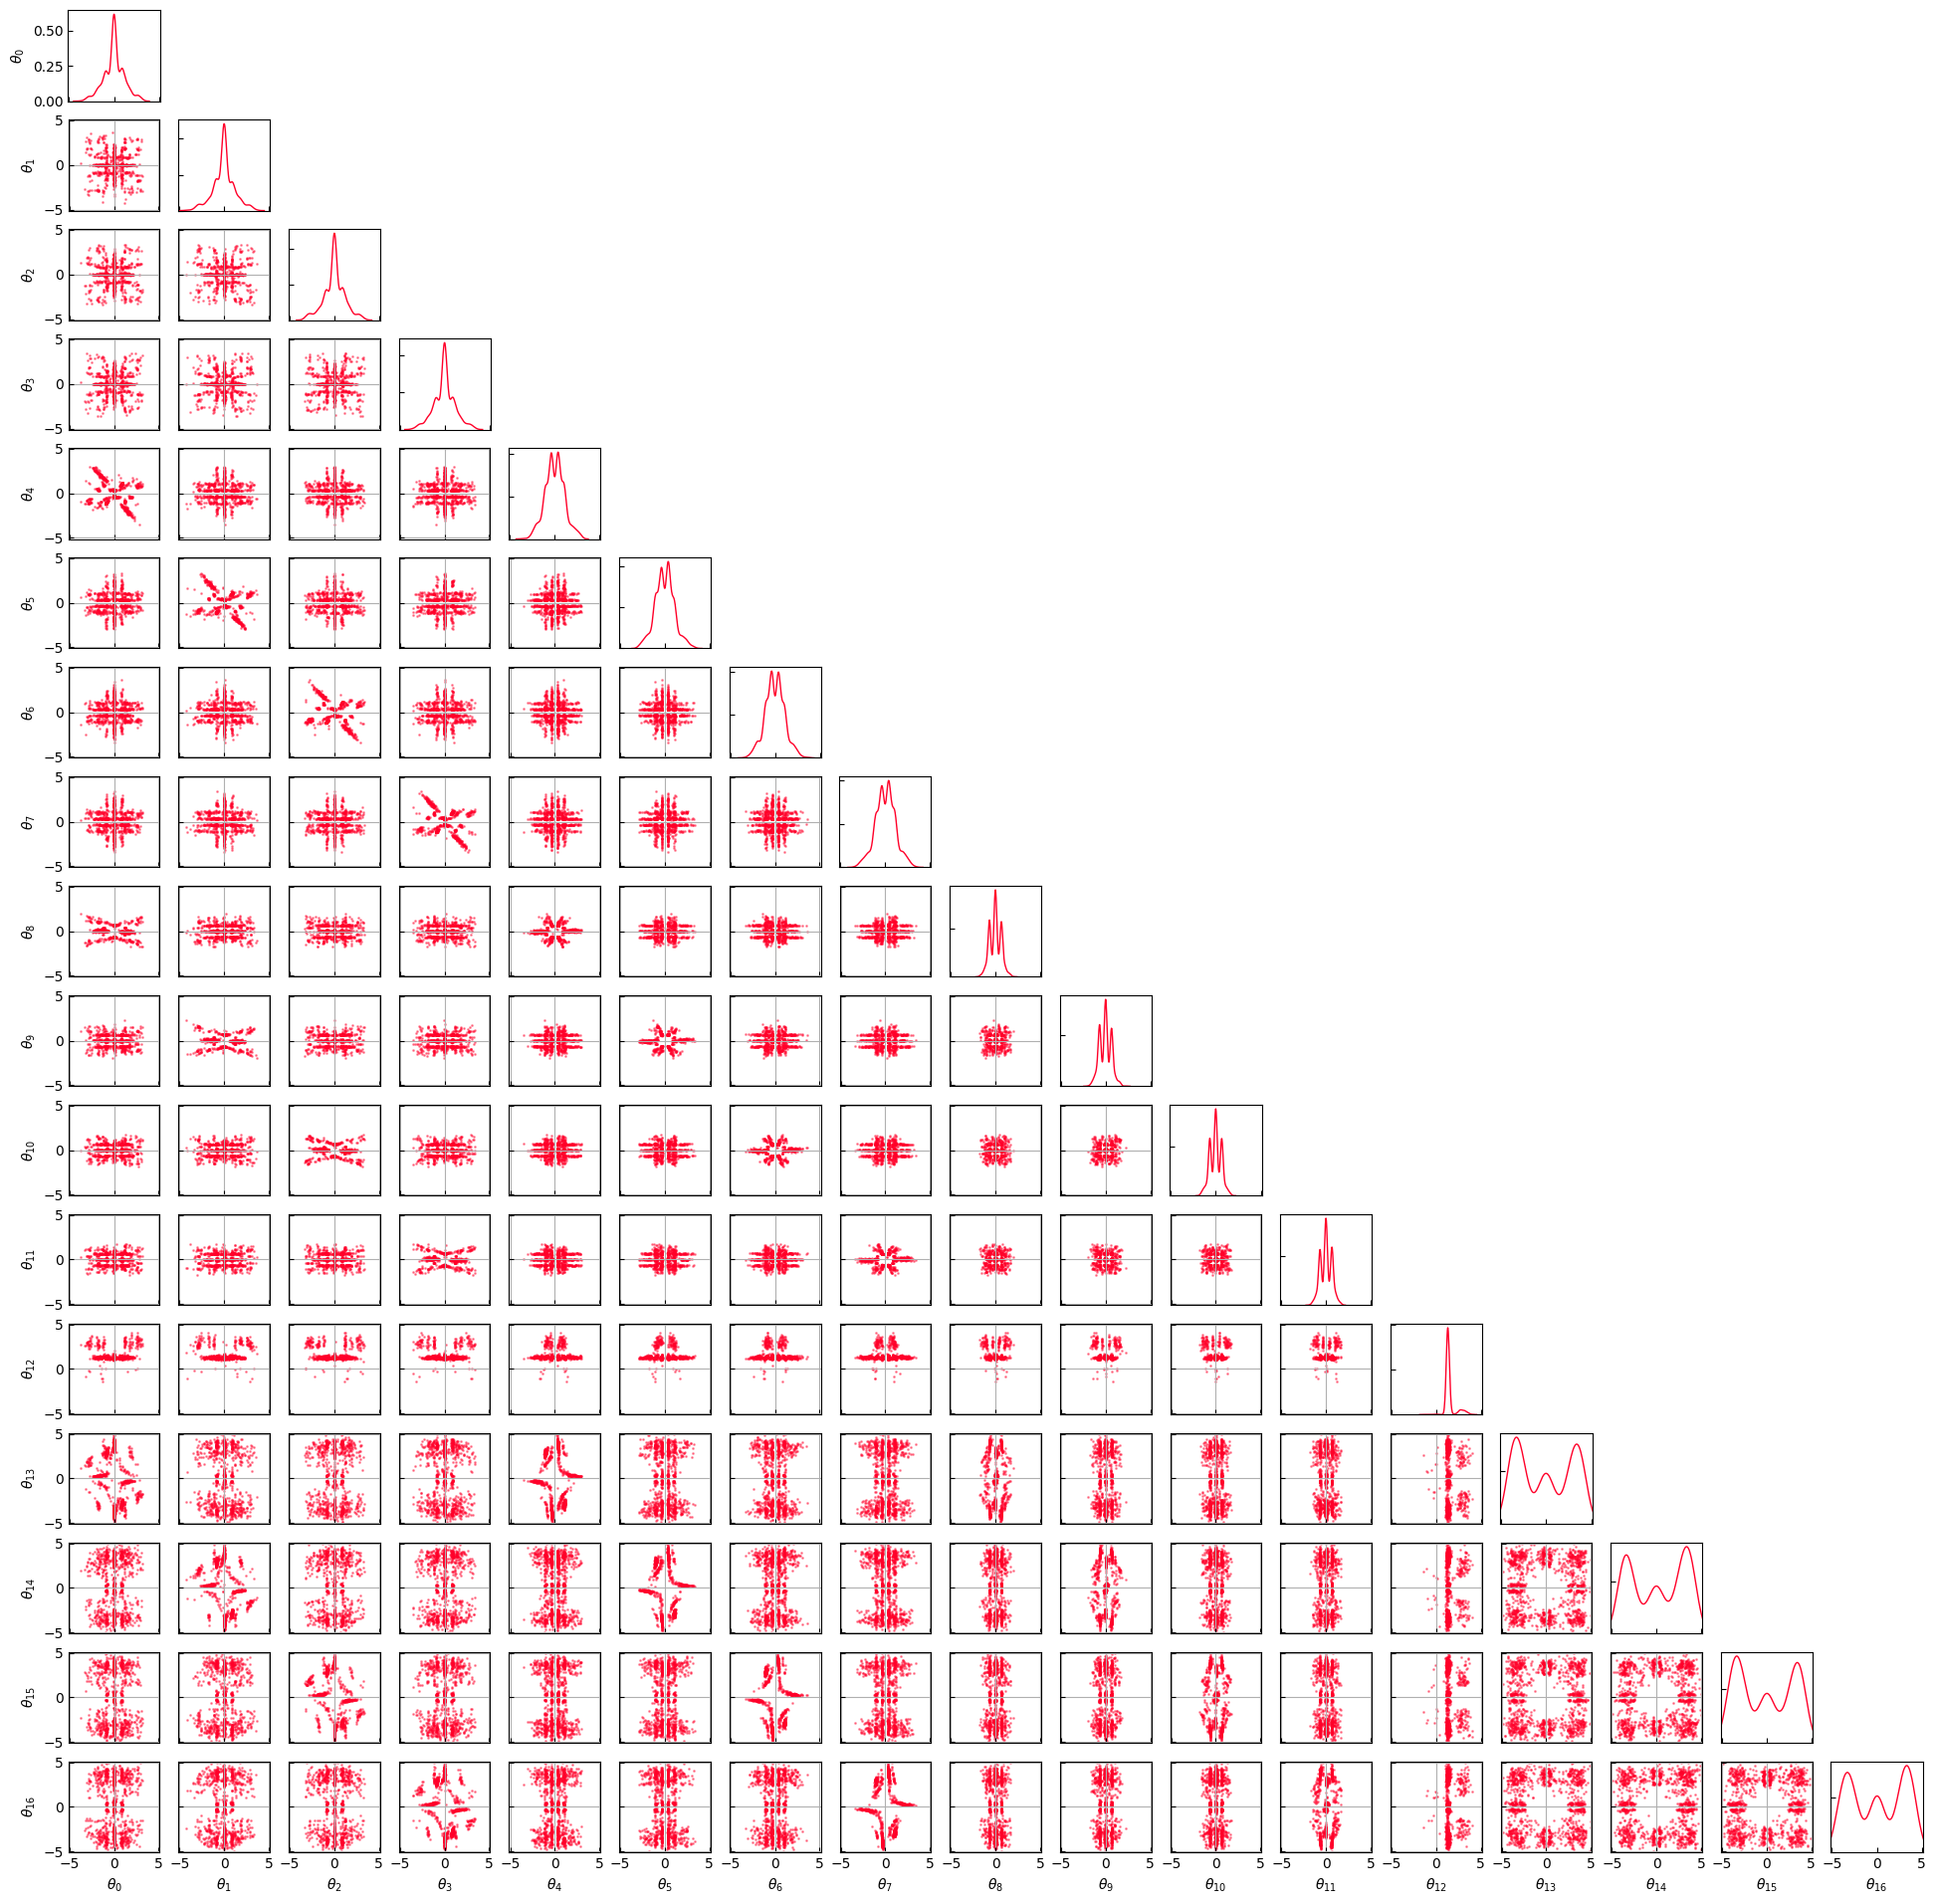

In [15]:
rng_key, rng_key_ = jax.random.split(rng_key)
samples_parameters_posterior = samples_parameters_fs
#if samples_parameters_posterior.shape[-1] > 10:
#    samples_parameters_posterior = samples_parameters_posterior[:, jax.random.permutation(rng_key_, jnp.arange(samples_parameters_fs.shape[-1]))[:10]]

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.4,
            size=1.0
        )
    )
)
figure.plot(
    data_list=[samples_parameters_posterior]
)